# 分布检验和拟合优度 $\chi^2$ 检验

## KS检验

In [1]:
ind <- c(15.04, 15.36, 14.57, 14.53, 15.57, 14.69, 15.37, 14.66, 14.52, 15.41,
         15.34, 14.28, 15.01, 14.76, 14.38, 15.87, 13.66, 14.97, 15.29, 14.95)

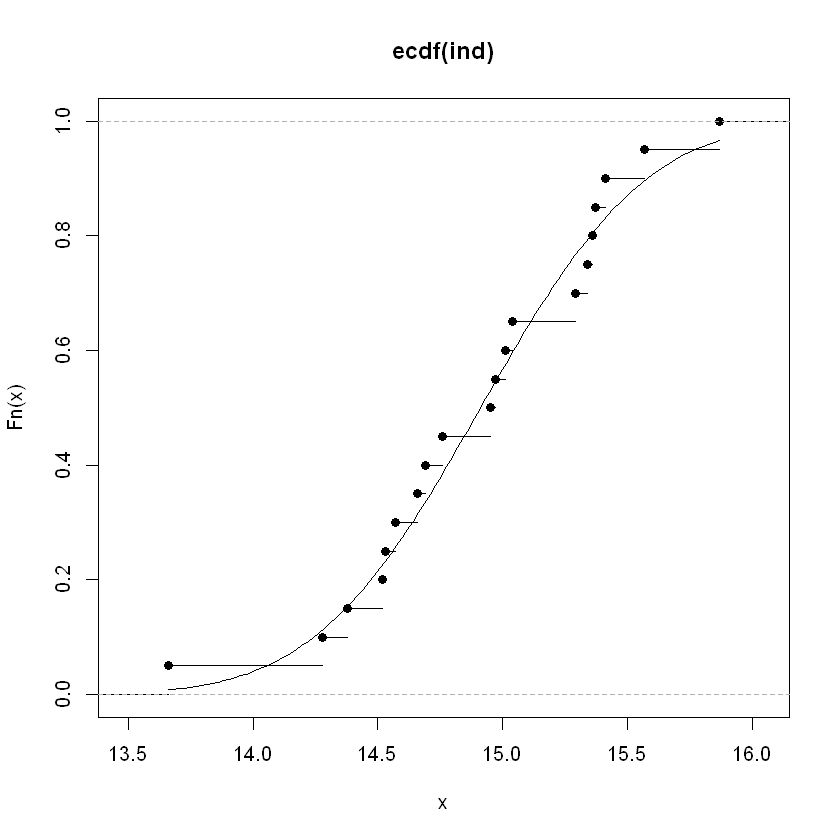

In [2]:
plot(ecdf(ind))
mu <- mean(ind)
sigma <- sd(ind)
x <- seq(min(ind), max(ind), length = 100)
lines(x, pnorm(x, mu, sigma))

直观上我们感觉样本的经验分布函数如果与给定的确定分布的函数相差甚远，那么样本出自那个分布的就显得荒谬。事实上，KS统计量

$$
D = \sup_x \mid S(X) - F_0(X) \mid
$$

定义为经验分布函数与给定总体分布函数的最大差别（绝对差上确界）。给定总体分布和样本规模下经验分布函数是具有固定分布的随机“变量”
（有点像随机过程），而它的KS统计量在给定总体分布函数（考察功效时这里这个总体分布函数不变，但总体分布变了）后也具是有确定分布的随机变量，
当然在总体分布与KS统计量的总体分布函数不一致的情况下（考察功效时用的），D统计量的分布就不知道了，这也是非参数检验的特征，
它只有在零假设成立下才有distribution-free的分布。

D统计量的精确分布是一个复杂的多重积分。故而常用它的$n \to \infty$的近似结果，有其分布函数为

$$
P(\sqrt{n}D_n < x) \to K(x) \\
K(x) = 
\begin{cases}
0, & x<0 \\
\sum_{j= -\infty}^\infty (-1)^j \exp(-2j^2 x^2), & x>0 
\end{cases}
$$

由于检验分布函数定义的阶梯函数性和分布函数递增的特点，KS统计量的计算特别方便。显而易见，对于每个$[x_i,x_{i+1}])$型区间，
它的最大绝对差可以在$(ecdf(x_1) - cdf(x_1),ecdf(x_1) - cdf(x_2),ecdf(x_2)-cdf(x_1),ecdf(x_2)-cdf(x_2))$四个点中取得。
所以整个最大值可以如此取得

$$
D_n  = \max_{1 \le i \le n} \{ \max(|S(x_i)-F_0(x_i)|, |S(x_{i-1}) - F_0(x_i)| ) \}
$$

其中$S(x)$为经验分布函数，$F_0(x)$为给定的确定分布函数。

说KS统计量好算，是考虑比较如下的Cramer-von Mises统计量的结果。

$$
W^2 = \int w_n^2(x)dF(x) \\
U^2 = n \int \{  w_n(x) - \int w_n(t) dF(t) \}^2 dF(x)
$$

看看这些积分，那些$F(x)$说不定都没有显示表达式。简直太糟了。

In [3]:
ks.test(ind,"pnorm",mu,sigma)


	One-sample Kolmogorov-Smirnov test

data:  ind
D = 0.11599, p-value = 0.9226
alternative hypothesis: two-sided


In [4]:
K <- function(x, j = seq(-100,100)){
    if(x <= 0){
        return(0)
    }
    sum((-1)^j * exp(-2*j^2*x^2))
}

In [5]:
Dn <- function(arr, cdf){
    arr <- sort(arr)
    n <- length(arr)
    fa <- seq(1,n)/n
    ffa <- cdf(arr)
    fffa <- c(NA,fa[1:(n-1)])
    max(c(abs(fa - ffa),abs(fffa - ffa)),na.rm=TRUE)
}

In [6]:
Dn(ind,function(x){pnorm(x,mu,sigma)})

[1] 0.1159913

In [7]:
1 - K(sqrt(length(ind))*Dn(ind,function(x){pnorm(x,mu,sigma)}))

[1] 0.9506875

In [8]:
ks.test(ind,"pnorm",mu,sigma,exact=F)


	One-sample Kolmogorov-Smirnov test

data:  ind
D = 0.11599, p-value = 0.9507
alternative hypothesis: two-sided


`shapiro.test`是比`ks.test`拥有更高势的检验，这可以由以下表格看出。各行是检验方法，各列是给定分布。每个格进行若干次模拟，
每次模型从总体中抽出一个一定规模的样本，得到其p值，然后即各次模拟平均p值于格中。另一个表则给出按0.05显著性水平和p值式拒绝域
（这时可以看成p值是原统计量又一次映射（放到原统计量分布函数里）的结果，此时p值也成了统计量，服从0,1上的均匀分布，
一般我们把靠小的那段划为拒绝域）。显然我们希望假设正确时格上取较大的p值或较低的功效值。而在假设错误时取较小的p值和较大的功效值。

以上是改变背后分布，而假设检验和检验统计量则都当做总体是正态分布的检验结果，我们这时当然希望正态列和非正态列呈现上述所述差异。

该表可以容纳（但和上表不等价，不是说一个表可以做两个理解）一种是改变假设检验和检验统计量为假设其为各种分布，而背后分布一直是正态分布。
看看错误率如何。

In [9]:
experiment <- function(test, p.count = 200, size = 30){
    # test: arr -> p.value
    rl <- list()
    exper <- function(r, ...){
        arg <- as.list(c(size, ...))
        replicate(p.count, test( do.call(r,arg) ))
    }
    
    rl[['N(0,1)']] <- exper(rnorm,0,1)
    rl[['Exp(1)']] <- exper(rexp,1)
    rl[['Gamma(1,2)']] <- exper(rgamma,1,2)
    rl[['U(1,2)']] <- exper(runif,1,2)
    rl[['t(1)']] <- exper(rt,1)
    rl[['chi2(1)']] <- exper(rchisq,1)
    rl[['F(1,2)']] <- exper(rf,1,2)
    
    return(rl)
}

In [10]:
shapiro.res <- experiment(function(arr)shapiro.test(arr)$p.value)

In [11]:
sapply(shapiro.res,mean)

N(0,1)       Exp(1)   Gamma(1,2)       U(1,2)         t(1)      chi2(1) 
5.063215e-01 4.759528e-03 5.535058e-03 1.117590e-01 1.879533e-02 2.962376e-04 
      F(1,2) 
4.639407e-06

In [12]:
sapply(shapiro.res,function(ps){mean(ps < 0.05)})

N(0,1)     Exp(1) Gamma(1,2)     U(1,2)       t(1)    chi2(1)     F(1,2) 
     0.045      0.970      0.980      0.445      0.950      1.000      1.000

In [13]:
ks.res <- experiment(function(arr){
    mu <- mean(arr)
    sigma <- sd(arr)
    ks.test(arr, 'pnorm', mu, sigma)$p.value
})

In [14]:
sapply(ks.res,mean)

N(0,1)      Exp(1)  Gamma(1,2)      U(1,2)        t(1)     chi2(1) 
0.794826901 0.241679441 0.274338317 0.668047067 0.061296885 0.088795669 
     F(1,2) 
0.006263478

In [15]:
sapply(ks.res,function(ps){mean(ps < 0.05)})

N(0,1)     Exp(1) Gamma(1,2)     U(1,2)       t(1)    chi2(1)     F(1,2) 
      0.00       0.13       0.12       0.00       0.75       0.50       0.98

In [16]:
x <- c(5.38, 4.38, 9.33, 3.66, 3.72, 1.66, 0.23, 0.08, 2.36, 1.71, 2.01, 0.90, 1.54)
y <- c(6.67, 16.21, 11.93, 9.85, 10.43, 13.54, 2.40, 12.89, 9.30, 11.92, 5.74, 14.45, 1.99, 9.14, 2.89)

In [17]:
ks.test(x,y)


	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.72308, p-value = 0.0004714
alternative hypothesis: two-sided


双样本问题中除了直接检验它们分布相等，还可以检验它们位置是否相等，如果不相等，自然也就不是同一个分布了。
然而这些位置参数的检验往往假设了分布除了位置外相等甚至还指定了那个分布是哪个分布（如正态分布）。

In [18]:
t.test(x,y)


	Welch Two Sample t-test

data:  x and y
t = -4.7653, df = 22.524, p-value = 8.793e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -9.248876 -3.644970
sample estimates:
mean of x mean of y 
 2.843077  9.290000 


In [19]:
wilcox.test(x,y)


	Wilcoxon rank sum test

data:  x and y
W = 21, p-value = 0.0001785
alternative hypothesis: true location shift is not equal to 0


对于与分布无关的检验，可以考虑Brown-Mood检验，虽然它本身是检验中位数的，但显然检验哪个数如果拒绝都可以表明它们分布不同。
但我们宁可选择检验中位数。

In [22]:
m <- median(c(x,y))

mat <- matrix(rep(NA,4),2)

mat[1,1] <- sum(x > m)
mat[2,1] <- sum(x < m)
mat[1,2] <- sum(y > m)
mat[2,2] <- sum(y < m)

mat

2,12
11,3


In [23]:
fisher.test(mat)


	Fisher's Exact Test for Count Data

data:  mat
p-value = 0.001838
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.003740508 0.416955640
sample estimates:
odds ratio 
0.05322453 


这个等价于显示进行Brown-Mood检验

In [28]:
phyper(mat[1,1], sum(mat[,1]), sum(mat[,2]), sum(mat[1,])) * 2

[1] 0.001838142

尽管这个P值大了不少，还是可以以0.01显著性水平拒绝原假设位置相同，从而分布也不相同。

## Pearson 拟合优度检验

Pearson拟合优度检验将分布值域划分为若干个格，给定分布在格上有理论概率或频数，而样本在格上有观测频率或频数。
显然可以以理论与观测的偏离来刻画两者的偏离。集中这一点的就是Pearson统计量$Q$。

$$
Q = \sum_{i=1}^k \frac{(N_i - np_{i0})^2}{np_{i0}} = \sum_{i=1}^k \frac{(O_i - E_i)^2}{E_i}
$$

这里的核心是集中单格偏离程度的统计量，pearson剩余 

$$
\frac{Q_i - E_i}{\sqrt{E_i}}
$$

这个看起来有点奇怪，因为单格理论服从二项分布，如果只看一个格子的话，按标准化的套路，单格统计量应该是这个样子的。

$$
\frac{O_i - E(O_i)}{\sqrt{Var(O_i)}} = \frac{O_i - E_i}{\sqrt{np_{i0}(1-p_{i0})}} = \frac{O_i - E_i}{\sqrt{\frac{E_i(N - E_i)}{N}}}
$$

当然两者在$\frac{E_i}{N} \to 0$，即很多格时应该是等价的，但这个设定怎么回事呢？

显然是因为这些格之间相关（它们加起来等于常数，显然），事实上这导致了秩降了1.为了证明其服从卡方分布，一种方式就是去相关标准化。
这个过程一般只在原来的变量上做线性变换是完不成的（即变换矩阵是对角矩阵）。不过这里成功地证明了其的确服从卡方分布。(定理详细描述见《数理统计学教程》定理3.1，证明见P113，用上了特征函数和二次型的理论，并不没有标准化的直观)。

更直接的构造方法是利用多项分布的协方差矩阵直接推导出解析的变换矩阵，它将原变量组变换为新的i.i.d的$N(0,1)$的部分变量组
（会少一个变量，或者没少但有一个新变量是0常数）。
然后做平方和，顺便看看能不能化简（显然变换矩阵乘任何正交矩阵仍是合法的变换矩阵，也许在其正交变换可达空间中找到一种特别简单的，比如上面那种也许就包含在内），我记得wiki上写了多项分布的协方差矩阵，然而忘了，现在也上不了网就不试了。

Fisher证明的更复杂的定理（《数理统计学教程》定理3.2）指出如果分布有些参数进行了极大似然估计来得到确定分布，则自由度还要减去估计的参数个数。这个证明更是在
《数理统计学教程》中都没有给出（上一个定理则是连同作者的《概率论与数理统计》也没有给出证明），证明见同作者《高等数理统计学》P242

In [32]:
X <- c(0,1,2,3)
N <- c(490, 334, 68, 16)

lam <- sum(N*X)/sum(N)
lam

[1] 0.5704846

In [35]:
the <- dpois(X,lam)*sum(sum(N))
the

[1] 513.24833 292.80026  83.51902  15.88210

In [37]:
chi <- sum(((the - N)/sqrt(the))^2)
chi

[1] 9.734785

In [39]:
pchisq(chi,length(X)-2,low=F)

[1] 0.007693399